In [1]:
import json
import torch
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import pickle
import numpy as np
from matplotlib.lines import Line2D

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

import sys
from pathlib import Path
# Go up one level from training_scripts/ to the project root
project_root = Path().resolve().parent
sys.path.append(str(project_root))

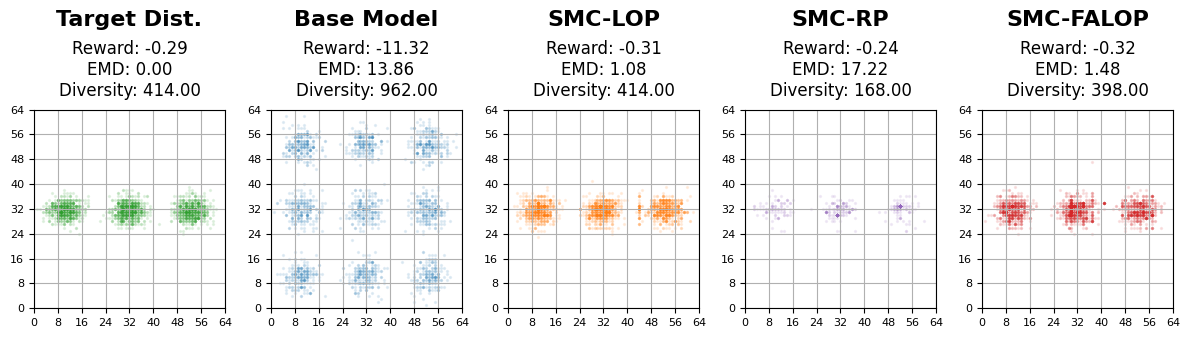

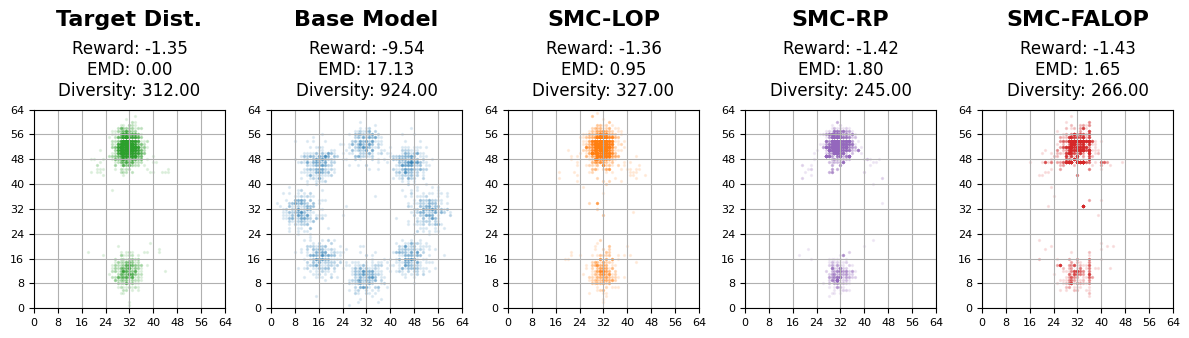

In [24]:
def plot_gmm_comparison(all_experiments_dump, save_file=None):

    # 1) Load both datasets
    with open(all_experiments_dump, "rb") as f:
        all_experiments = pickle.load(f)

    BASE_MODEL = "BASE_MODEL"
    TARGET_DIST = "TARGET"
    SMC_LOP = "SMC_LOP"
    SMC_RP = "SMC_RP"
    SMC_FALOP = "SMC_FALOP"


    # 2) Column order and colors
    col_order  = [TARGET_DIST, BASE_MODEL, SMC_LOP, SMC_RP, SMC_FALOP]
    col_titles = {
        BASE_MODEL:      "Base Model",
        TARGET_DIST:     "Target Dist.",
        SMC_LOP:         "SMC-LOP",
        SMC_RP:          "SMC-RP",
        SMC_FALOP:       "SMC-FALOP",
    }
    col_colors = {
        BASE_MODEL:      "tab:blue",
        TARGET_DIST:     "tab:green",
        SMC_LOP:         "tab:orange",
        SMC_RP:          "tab:purple",
        SMC_FALOP:       "tab:red",
    }

    # 3) Plot
    n_rows, n_cols = 1, len(col_order)
    fig, axes = plt.subplots(n_rows, n_cols,
                            figsize=(12, 3.88),
                            squeeze=False)

    i = 0
    for j, meth in enumerate(col_order):
        ax = axes[i, j]
        experiment = all_experiments[meth]
        X = experiment[0]["results"]["X_0"]
        if type(X) == torch.Tensor:
            X = X.detach().cpu().numpy()
        r = experiment[0]["metrics"]["reward"]
        e = experiment[0]["metrics"]["emd"]
        diversity = experiment[0]["metrics"]["diversity"]

        # scatter with your chosen color
        ax.scatter(X[:,0], X[:,1],
                s=2, alpha=0.1,
                color=col_colors[meth])

        ax.set_xlim(0, 64)
        ax.set_ylim(0, 64)
        ax.set_xticks([tick for tick in range(0, 65, 8)])
        ax.set_yticks([tick for tick in range(0, 65, 8)])
        ax.tick_params(axis='both', labelsize=8)
        ax.grid(True)

        
        # 1) Main title line (only top row), even higher
        if i == 0:
            ax.text(
                0.5, 1.4,                       # <-- y bumped up from 1.12 → 1.18
                col_titles[meth],
                transform=ax.transAxes,
                ha="center", va="bottom",
                fontsize=16,
                fontweight="bold" 
            )

        # 2) Subtitle with reward/EMD, pushed further down
        subtitle = f"Reward: {r:.2f}"
        if e is not None:
            subtitle += f"\nEMD: {e:.2f}"
        if diversity is not None:
            subtitle += f"\nDiversity: {diversity:.2f}"
        ax.set_title(subtitle,
                    fontsize=12,
                    pad=10)                    # <-- increased pad from 20 → 25

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5)  # <-- increase vertical space between rows
    if save_file is not None:
        plt.savefig(save_file, format="pdf", bbox_inches="tight")
    plt.show()
    
plot_gmm_comparison("outputs/smc_mdm_gmm1/20250901-202824/all_experiments.pkl", save_file="plots/gmm1_scatterplot.pdf")
plot_gmm_comparison("outputs/smc_mdm_gmm2/20250901-212432/all_experiments.pkl", save_file="plots/gmm2_scatterplot.pdf")

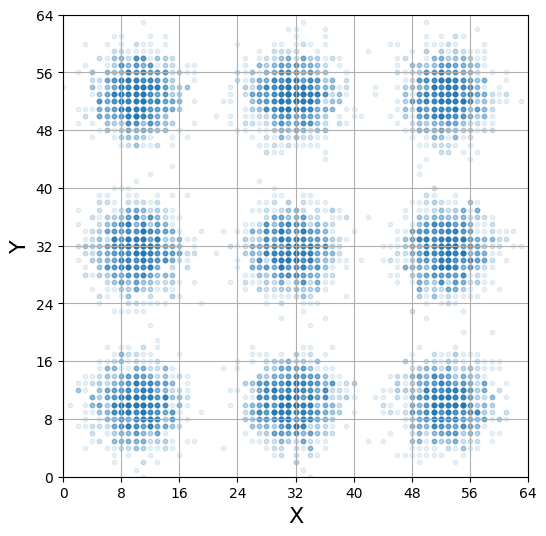

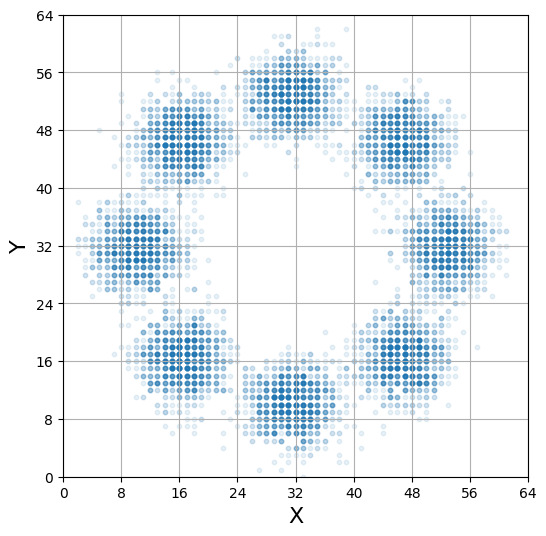

In [36]:
from datasets_local.gaussian_mixture import generate_samples

def plot_gmm_datasets(type, save_file=None):
    samples = generate_samples(type=type, n_grid_points=64, batch_size=10000)
    plt.figure(figsize=(6, 6))
    plt.scatter(samples[:, 0], samples[:, 1], s=10, alpha=0.1)
    plt.xlim(0, 64)
    plt.ylim(0, 64)
    plt.xlabel('X', fontsize=16)
    plt.ylabel('Y', fontsize=16)
    plt.xticks([tick for tick in range(0, 65, 8)])
    plt.yticks([tick for tick in range(0, 65, 8)])
    plt.grid(True)
    if save_file:
        plt.savefig(save_file, format="pdf", bbox_inches="tight")
    plt.show()
    
plot_gmm_datasets("1", save_file="plots/gmm1_dataset.pdf")
plot_gmm_datasets("2", save_file="plots/gmm2_dataset.pdf")

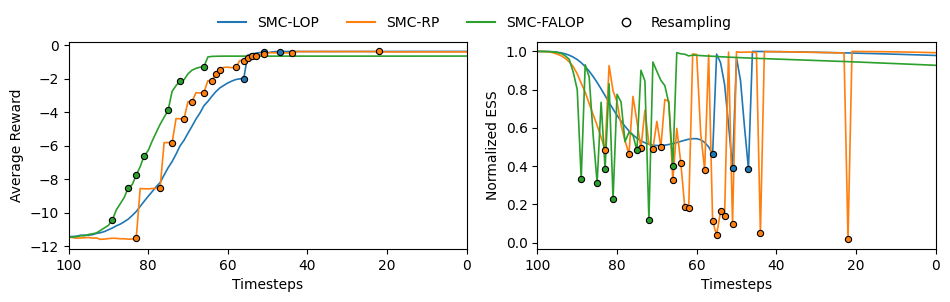

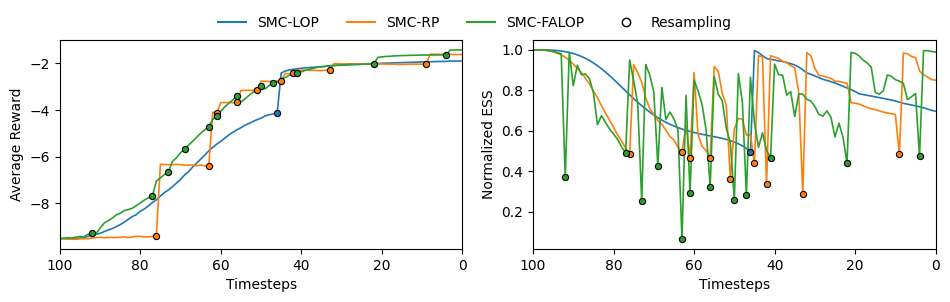

In [68]:
def plot_all_traces(all_experiments_dump, save_file=None):
    """
    data_files: list of two paths, e.g. ["plot_data/smc_mdm_gmm1.pkl", "plot_data/smc_mdm_gmm2.pkl"]
    save_files: corresponding list of two base names (not used here but could be for titles)
    trace_types: list of two strings, ["reward", "ess"]
    """
    BASE_MODEL = "BASE_MODEL"
    TARGET_DIST = "TARGET"
    SMC_LOP = "SMC_LOP"
    SMC_RP = "SMC_RP"
    SMC_FALOP = "SMC_FALOP"
    methods  = [SMC_LOP, SMC_RP, SMC_FALOP]
    labels = {
        BASE_MODEL:      "Base Model",
        TARGET_DIST:     "Target Dist.",
        SMC_LOP:         "SMC-LOP",
        SMC_RP:          "SMC-RP",
        SMC_FALOP:       "SMC-FALOP",
    }
    markers = {
        SMC_LOP:"o",
        SMC_RP:        "o",
        SMC_FALOP:    "o",
    }
    timesteps = np.arange(100, -1, -1)  # 100 → 0

    fig, axes = plt.subplots(1, 2, figsize=(12 * 0.8, 4 * 0.8))

    # Prepare custom legend handles including line style and a separate resample entry
    legend_handles = []
    legend_labels = []
    for method in methods:
        # Generate a prototype handle for each method
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][methods.index(method)]
        handle = Line2D(
            [0], [0],
            color=color,
            lw=1.5,
            label=labels[method]
        )
        legend_handles.append(handle)
        legend_labels.append(labels[method])
    
    # Add a generic resampling marker entry
    res_handle = Line2D(
        [0], [0],
        color='white',  # invisible line
        marker='o',
        markerfacecolor='none',
        markeredgecolor='black',
        markersize=6,
        linestyle='None',
        label='Resampling'
    )
    legend_handles.append(res_handle)
    legend_labels.append('Resampling')

    with open(all_experiments_dump, "rb") as f:
        all_experiments = pickle.load(f)
        

    for j, trace_type in enumerate(["rewards", "ess"]):
        ax = axes[j]
        for method in methods:
            # Results from one of the runs
            run = 7
            results = all_experiments[method][run]["results"]
            
            td = np.array(results[f"{trace_type}_trace"])
            trace_data = td.mean(axis=1) if trace_type == "rewards" else td / 2000

            resamps = np.array(results["resampling_trace"][:-1])
            y_resamp = trace_data[100 - resamps]

            # print(timesteps.shape, trace_data.shape)

            # plot line
            line = ax.plot(
                timesteps,
                trace_data,
                color=plt.rcParams['axes.prop_cycle'].by_key()['color'][methods.index(method)],
                linewidth=1.2
            )
            # filled marker at resamples
            ax.scatter(
                resamps,
                y_resamp,
                marker=markers[method],
                s=20,
                color=line[0].get_color(),
                edgecolors='black',
                linewidths=0.8,
                zorder=3
            )

        ax.invert_xaxis()
        ax.set_xlim(100, 0)
        # ax.set_xlabel(r"Timestep $100.\tau$")
        ax.set_xlabel("Timesteps")
        ylabel = "Average Reward" if trace_type == "rewards" else "Normalized ESS"
        ax.set_ylabel(ylabel)

    # Add single legend at top including custom handles
    fig.subplots_adjust(top=0.88)
    fig.legend(
        legend_handles,
        legend_labels,
        loc='upper center',
        ncol=len(legend_handles),
        frameon=False,
        bbox_to_anchor=(0.5, 0.95)
    )

    plt.tight_layout(rect=[0, 0, 1, 0.88])  # leave space at top for legend
    if save_file is not None:
        plt.savefig(save_file, format="pdf", bbox_inches="tight")
    plt.show()
    
plot_all_traces("outputs/smc_mdm_gmm1/20250901-202824/all_experiments.pkl", save_file="plots/gmm1_traces.pdf")
plot_all_traces("outputs/smc_mdm_gmm2/20250901-212432/all_experiments.pkl", save_file="plots/gmm2_traces.pdf")

In [3]:
from smc.utils import (
    compute_ess_from_log_w,
    normalize_log_weights, 
    normalize_weights
)

def test(all_experiments_dump):
    with open(all_experiments_dump, "rb") as f:
        all_experiments = pickle.load(f)
        
    BASE_MODEL = "BASE_MODEL"
    TARGET_DIST = "TARGET"
    SMC_LOP = "SMC_LOP"
    SMC_RP = "SMC_RP"
    SMC_FALOP = "SMC_FALOP"
    run = 7
    
    results = all_experiments[SMC_RP][run]["results"]
    
    print(results["resampling_trace"][:-1])
    particles_trace = results["particles_trace"]
    print(len(particles_trace), particles_trace[0].shape)
    log_weights_trace = results["log_weights_trace"]
    print(len(log_weights_trace), log_weights_trace[0].shape)
    
    rewards_trace = results["rewards_trace"]
    print(len(rewards_trace), rewards_trace[0].shape)
    
    log_w_t = log_weights_trace[100 - 23]
    log_w_s = log_weights_trace[100 - 22]
    print("At t", compute_ess_from_log_w(torch.tensor(log_w_t)))
    print("At s", compute_ess_from_log_w(torch.tensor(log_w_s)))
    
    particles_t = particles_trace[100 - 23]
    particles_s = particles_trace[100 - 22]
    
    print("Fixed particles at t", ((particles_t[:, 0] < 64) & (particles_t[:, 1] < 64)).sum())
    print("Fixed particles at s", ((particles_s[:, 0] < 64) & (particles_s[:, 1] < 64)).sum())
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].scatter(particles_t[:, 0], particles_t[:, 1], s=10, alpha=0.1)
    ax[0].set_title("Particles at t")
    ax[0].set_xlim(0, 64)
    ax[0].set_ylim(0, 64)
    ax[1].scatter(particles_s[:, 0], particles_s[:, 1], s=10, alpha=0.1)
    ax[1].set_title("Particles at s")
    ax[1].set_xlim(0, 64)
    ax[1].set_ylim(0, 64)
    
    plt.show()
    
    rewards_t = rewards_trace[100 - 23]
    rewards_s = rewards_trace[100 - 22]
    
    print("At t", rewards_t.mean())
    print("At s", rewards_s.mean())
    
    fig, ax = plt.subplots(1, 3, figsize=(12, 5))
    ax[0].hist(rewards_t, bins=30)
    ax[0].set_title("Rewards at t")
    ax[1].hist(rewards_s, bins=30)
    ax[1].set_title("Rewards at s")
    # ax[2].hist(rewards_s - rewards_t, bins=30)
    diffs = rewards_s - rewards_t
    ax[2].hist(diffs[np.abs(diffs) > 0.1], bins=30)
    ax[2].set_title("Rewards diff s - t")
    plt.show()
    
    anomaly_particle = diffs.argmax()
    print("Anomalous particle index", anomaly_particle)
    
    print(diffs[np.abs(diffs) > 0.1])
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].hist(log_w_t, bins=30)
    ax[0].set_title("Log weights at t")
    ax[1].hist(log_w_s, bins=30)
    ax[1].set_title("Log weights at s")
    ax[0].set_yscale('log')
    ax[1].set_yscale('log')
    plt.show()
    
    print("log_w_t anomaly", log_w_t[anomaly_particle])
    print("log_w_s anomaly", log_w_s[anomaly_particle])
    
    print("particle anomaly", particles_t[anomaly_particle])
    print("particle anomaly", particles_s[anomaly_particle])
    
    print("reward anomaly at t", rewards_t[anomaly_particle])
    print("reward anomaly at s", rewards_s[anomaly_particle])
    
# test("outputs/smc_mdm_gmm1/20250901-202824/all_experiments.pkl")
test("outputs/smc_mdm_gmm2/20250902-171755/all_experiments.pkl")

EOFError: Ran out of input

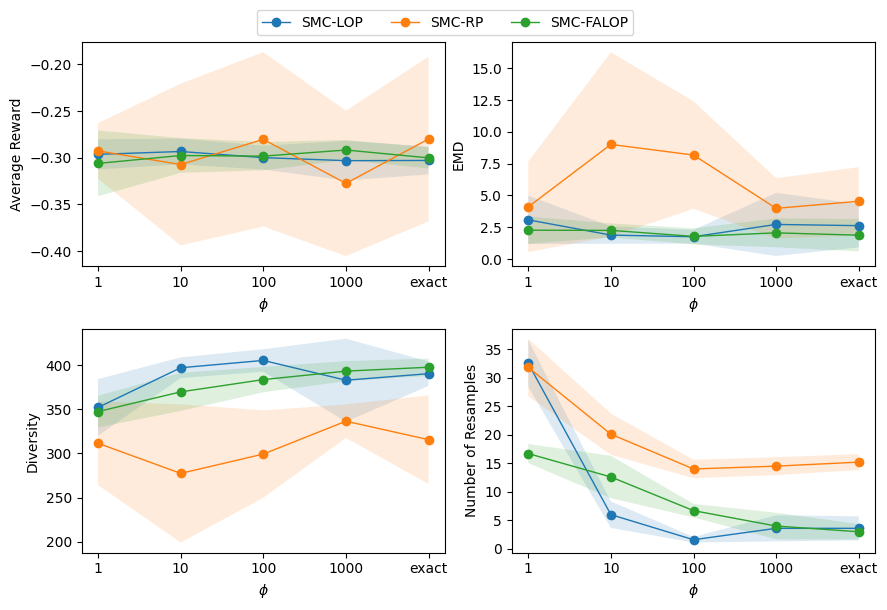

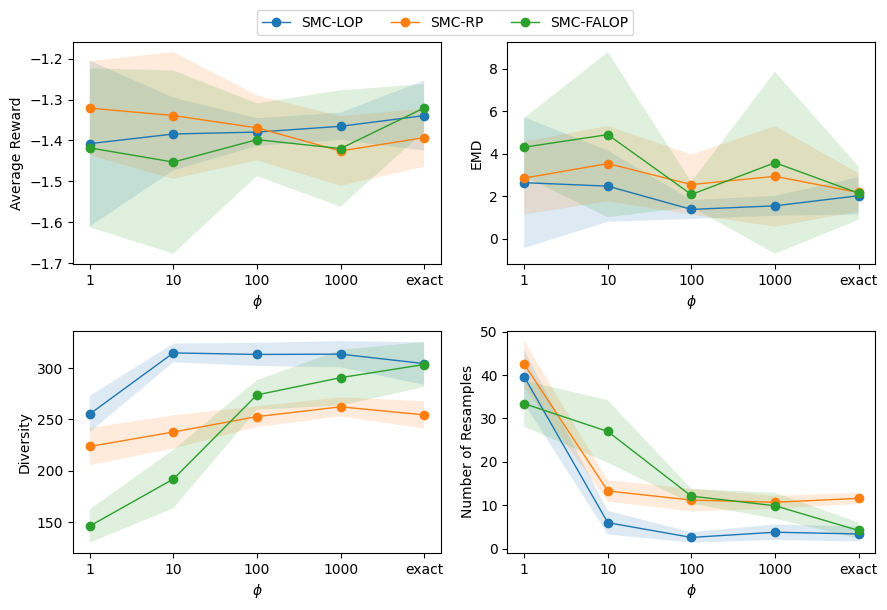

In [21]:
def plot_ablation_phi(all_experiment_dumps, save_file=None, figsize=(12, 8)):
    SMC_LOP = "SMC_LOP"
    SMC_RP = "SMC_RP"
    SMC_FALOP = "SMC_FALOP"
    methods  = [SMC_LOP, SMC_RP, SMC_FALOP]
    labels = {
        SMC_LOP:   "SMC-LOP",
        SMC_RP:    "SMC-RP",
        SMC_FALOP: "SMC-FALOP",
    }

    fig, ax = plt.subplots(2, 2, figsize=figsize)
    metrics_to_plot = ["reward", "emd", "diversity", "resamples"]
    data = {}

    # load and organise
    for phi, pkl_path in all_experiment_dumps:
        with open(pkl_path, "rb") as f:
            all_experiments = pickle.load(f)

        for method in methods:
            results = all_experiments[method]
            rewards = [res["metrics"]["reward"] for res in results]
            emds = [res["metrics"]["emd"] for res in results]
            diversities = [res["metrics"]["diversity"] for res in results]
            resamples = [len(res["results"]["resampling_trace"]) - 1 for res in results]

            metrics = {
                "reward": rewards,
                "emd": emds,
                "diversity": diversities,
                "resamples": resamples
            }

            for metric in metrics_to_plot:
                key = (method, metric)
                if key not in data:
                    data[key] = {}
                data[key][phi] = metrics[metric]

    # simple phi ordering: numeric phis (int/float) first, others after
    def phi_sort_key(x):
        if isinstance(x, (int, float, np.integer, np.floating)):
            return (0, float(x))
        return (1, str(x))

    for metric in metrics_to_plot:
        idx = metrics_to_plot.index(metric)
        ax_i, ax_j = divmod(idx, 2)
        ax_ij = ax[ax_i, ax_j]

        phi_union = set()
        for method in methods:
            phi_union.update(data[(method, metric)].keys())
        phi_values_sorted = sorted(list(phi_union), key=phi_sort_key)
        x = np.arange(len(phi_values_sorted))

        for method in methods:
            method_data = data[(method, metric)]
            means = np.array([np.mean(method_data[phi]) for phi in phi_values_sorted], dtype=float)
            stds  = np.array([np.std(method_data[phi])  for phi in phi_values_sorted], dtype=float)

            # plot mean line
            ax_ij.plot(x, means, label=labels.get(method, method), marker='o', linewidth=1)

            # shaded area = mean +/- std
            lower = means - stds
            upper = means + stds
            ax_ij.fill_between(x, lower, upper, alpha=0.15)

        ax_ij.set_xticks(x)
        ax_ij.set_xticklabels([str(p) for p in phi_values_sorted])
        ax_ij.set_xlabel(r'$\phi$')

        ylabel = "Average Reward" if metric == "reward" else ("EMD" if metric == "emd" else ("Diversity" if metric == "diversity" else "Number of Resamples"))
        ax_ij.set_ylabel(ylabel)
        # no per-axis legend here

    # collect unique handles/labels from all axes and create a single legend at the top
    handles = []
    labels_unique = []
    for a in ax.flatten():
        h, l = a.get_legend_handles_labels()
        for hi, li in zip(h, l):
            if li not in labels_unique:
                handles.append(hi)
                labels_unique.append(li)
        # remove any per-axis legend if present
        if a.get_legend() is not None:
            a.get_legend().remove()

    # place figure legend above the subplots
    if handles:
        fig.legend(handles, labels_unique, loc='upper center',
                   ncol=len(labels_unique), bbox_to_anchor=(0.5, 1.02))

    plt.tight_layout(rect=[0, 0, 1, 0.98])  # leave room at top for the legend

    if save_file:
        plt.savefig(save_file, format="pdf", bbox_inches="tight")

    plt.show()

plot_ablation_phi(
    [
        (1,   "outputs/smc_mdm_gmm1/20250902-171314/all_experiments.pkl"),
        (10,  "outputs/smc_mdm_gmm1/20250902-173123/all_experiments.pkl"),
        (100, "outputs/smc_mdm_gmm1/20250902-174458/all_experiments.pkl"),
        (1000,"outputs/smc_mdm_gmm1/20250902-181155/all_experiments.pkl"),
        ("exact","outputs/smc_mdm_gmm1/20250902-182707/all_experiments.pkl"),
    ],
    save_file="plots/gmm1_phi_ablation.pdf",
    figsize=(9, 6)
)

plot_ablation_phi(
    [
        (1,   "outputs/smc_mdm_gmm2/20250902-181052/all_experiments.pkl"),
        (10,  "outputs/smc_mdm_gmm2/20250902-182515/all_experiments.pkl"),
        (100, "outputs/smc_mdm_gmm2/20250902-185427/all_experiments.pkl"),
        (1000,"outputs/smc_mdm_gmm2/20250902-190941/all_experiments.pkl"),
        ("exact","outputs/smc_mdm_gmm2/20250902-192413/all_experiments.pkl"),
    ],
    save_file="plots/gmm2_phi_ablation.pdf",
    figsize=(9, 6)
)

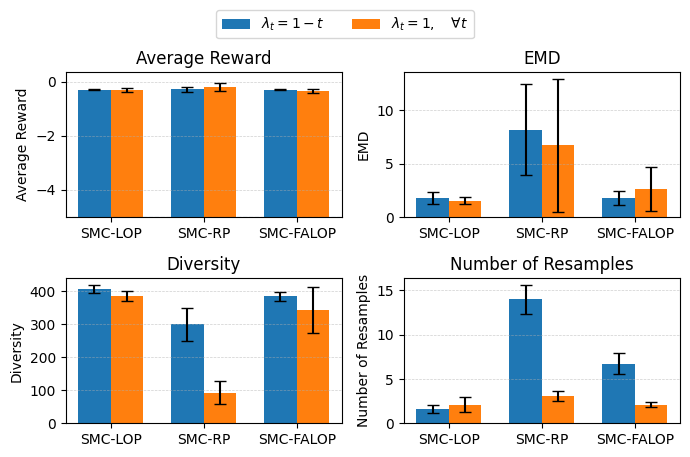

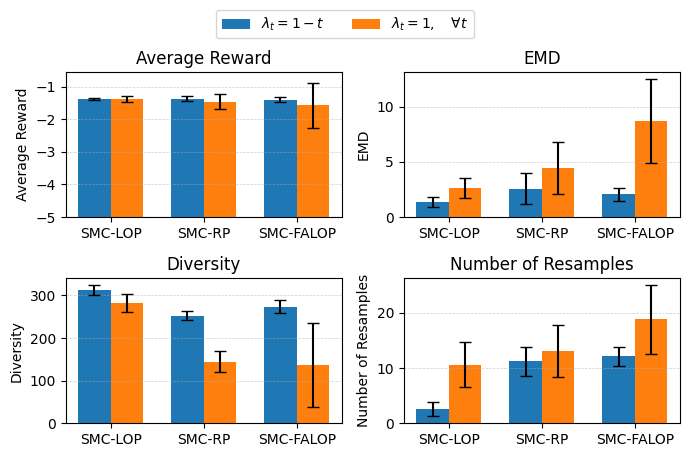

In [7]:
def plot_ablation_tempering(tempering_files, save_file=None, figsize=(9, 6), show_std=True):
    """
    tempering_files: dict-like with keys "tempering" and "no tempering" mapping to pickle paths,
      e.g. {"tempering": "path/to/with_tempering.pkl", "no tempering": "path/to/no_tempering.pkl"}
    save_file: optional path to save the figure
    show_std: if True, plot std as error bars on each bar
    """
    import pickle
    import numpy as np
    import matplotlib.pyplot as plt

    SMC_LOP = "SMC_LOP"
    SMC_RP = "SMC_RP"
    SMC_FALOP = "SMC_FALOP"
    methods = [SMC_LOP, SMC_RP, SMC_FALOP]
    method_labels = ["SMC-LOP", "SMC-RP", "SMC-FALOP"]

    # load pickles (assumes clean data)
    all_experiments_temp = pickle.load(open(tempering_files["tempering"], "rb"))
    all_experiments_notemp = pickle.load(open(tempering_files["no tempering"], "rb"))

    metrics_to_plot = ["reward", "emd", "diversity", "resamples"]
    stats = {"tempering": {m: {} for m in methods},
             "no_tempering": {m: {} for m in methods}}

    tempering_label = r"$\lambda_t = 1-t$"
    no_tempering_label = r"$\lambda_t = 1, \quad \forall t$"

    for m in methods:
        results_temp = all_experiments_temp[m]
        results_notemp = all_experiments_notemp[m]

        rewards_temp = np.array([r["metrics"]["reward"] for r in results_temp], dtype=float)
        emds_temp    = np.array([r["metrics"]["emd"]    for r in results_temp], dtype=float)
        divers_temp  = np.array([r["metrics"]["diversity"] for r in results_temp], dtype=float)
        resamps_temp = np.array([len(r["results"]["resampling_trace"]) - 1 for r in results_temp], dtype=float)

        rewards_notemp = np.array([r["metrics"]["reward"] for r in results_notemp], dtype=float)
        emds_notemp    = np.array([r["metrics"]["emd"]    for r in results_notemp], dtype=float)
        divers_notemp  = np.array([r["metrics"]["diversity"] for r in results_notemp], dtype=float)
        resamps_notemp = np.array([len(r["results"]["resampling_trace"]) - 1 for r in results_notemp], dtype=float)

        stats["tempering"][m]["reward"]   = (rewards_temp.mean(), rewards_temp.std())
        stats["tempering"][m]["emd"]      = (emds_temp.mean(), emds_temp.std())
        stats["tempering"][m]["diversity"]= (divers_temp.mean(), divers_temp.std())
        stats["tempering"][m]["resamples"]= (resamps_temp.mean(), resamps_temp.std())

        stats["no_tempering"][m]["reward"]   = (rewards_notemp.mean(), rewards_notemp.std())
        stats["no_tempering"][m]["emd"]      = (emds_notemp.mean(), emds_notemp.std())
        stats["no_tempering"][m]["diversity"]= (divers_notemp.mean(), divers_notemp.std())
        stats["no_tempering"][m]["resamples"]= (resamps_notemp.mean(), resamps_notemp.std())

    # plotting
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.flatten()
    width = 0.35
    x = np.arange(len(methods))

    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx]

        means_temp   = np.array([stats["tempering"][m][metric][0] for m in methods], dtype=float)
        stds_temp    = np.array([stats["tempering"][m][metric][1] for m in methods], dtype=float)
        means_notemp = np.array([stats["no_tempering"][m][metric][0] for m in methods], dtype=float)
        stds_notemp  = np.array([stats["no_tempering"][m][metric][1] for m in methods], dtype=float)

        if metric == "reward":
            # >>> draw bars from -10 upwards <<<
            base = -5.0
            heights_temp   = means_temp   - base  # == means_temp + 10
            heights_notemp = means_notemp - base  # == means_notemp + 10

            bars1 = ax.bar(x - width/2, heights_temp,   width, label=tempering_label,
                           bottom=base, yerr=(stds_temp if show_std else None),
                           capsize=4 if show_std else 0)
            bars2 = ax.bar(x + width/2, heights_notemp, width, label=no_tempering_label,
                           bottom=base, yerr=(stds_notemp if show_std else None),
                           capsize=4 if show_std else 0)

            # y-limits with a small headroom
            if show_std:
                top_candidate = max(np.max(means_temp + stds_temp), np.max(means_notemp + stds_notemp))
            else:
                top_candidate = max(np.max(means_temp), np.max(means_notemp))
            margin = 0.08 * (top_candidate - base)
            ax.set_ylim(base, top_candidate + margin)
            ax.axhline(base, linestyle='--', linewidth=0.8, alpha=0.8)
        else:
            # default bars starting at 0
            bars1 = ax.bar(x - width/2, means_temp,   width, label=tempering_label,
                           yerr=(stds_temp if show_std else None),
                           capsize=4 if show_std else 0)
            bars2 = ax.bar(x + width/2, means_notemp, width, label=no_tempering_label,
                           yerr=(stds_notemp if show_std else None),
                           capsize=4 if show_std else 0)

        ax.set_xticks(x)
        ax.set_xticklabels(method_labels)

        ylabel = "Average Reward" if metric == "reward" else ("EMD" if metric == "emd" else ("Diversity" if metric == "diversity" else "Number of Resamples"))
        ax.set_ylabel(ylabel)
        ax.set_title(ylabel)
        ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.6)

    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.02))

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    if save_file:
        plt.savefig(save_file, format="pdf", bbox_inches="tight")
    plt.show()


plot_ablation_tempering(
    {"tempering": "outputs/smc_mdm_gmm1/20250902-174458/all_experiments.pkl",
     "no tempering": "outputs/smc_mdm_gmm1/20250902-200408/all_experiments.pkl"},
    save_file="plots/gmm1_tempering_ablation.pdf",
    figsize=(7, 4.5),
    show_std=True
)
plot_ablation_tempering(
    {"tempering": "outputs/smc_mdm_gmm2/20250902-185427/all_experiments.pkl",
     "no tempering": "outputs/smc_mdm_gmm2/20250902-200302/all_experiments.pkl"},
    save_file="plots/gmm2_tempering_ablation.pdf",
    figsize=(7, 4.5),
    show_std=True
)


In [5]:
experiments_base_dir = 'outputs/smc_mdm_binarized_mnist_multi_runs'

for root, dirs, files in os.walk(experiments_base_dir):
    print(root, dirs, files)

outputs/smc_mdm_binarized_mnist_multi_runs ['20250904'] []
outputs/smc_mdm_binarized_mnist_multi_runs/20250904 ['185902', '190540', '191151', '191812', '192455', '193125', '193736', '194409', '195117', '195748', '200403', '201040', '201738', '202404', '203031', '203739'] []
outputs/smc_mdm_binarized_mnist_multi_runs/20250904/185902 [] ['metadata.json', 'args.json', 'all_experiments.pkl']
outputs/smc_mdm_binarized_mnist_multi_runs/20250904/190540 [] ['metadata.json', 'args.json', 'all_experiments.pkl']
outputs/smc_mdm_binarized_mnist_multi_runs/20250904/191151 [] ['metadata.json', 'args.json', 'all_experiments.pkl']
outputs/smc_mdm_binarized_mnist_multi_runs/20250904/191812 [] ['metadata.json', 'args.json', 'all_experiments.pkl']
outputs/smc_mdm_binarized_mnist_multi_runs/20250904/192455 [] ['metadata.json', 'args.json', 'all_experiments.pkl']
outputs/smc_mdm_binarized_mnist_multi_runs/20250904/193125 [] ['metadata.json', 'args.json', 'all_experiments.pkl']
outputs/smc_mdm_binarized_mni

In [ ]:
def mean_and_std(values):
    mean = np.mean(values)
    std = np.std(values)
    return mean, std

metric_list = ["reward", "reward_ext", "accuracy", "accuracy_ext", "diversity", "resamples"]
additional_metrics = [
    "success_one", 
    "success_one_ext",
    "success_all", 
    "success_all_ext"
]

BASE_MODEL = "BASE_MODEL"
IS_10K = "IS_10K"
SMC_LOP = "SMC_LOP"
SMC_RP = "SMC_RP"
SMC_FALOP = "SMC_FALOP"
methods = [
    # BASE_MODEL, 
    # IS_10K, 
    # SMC_RP, 
    SMC_FALOP
]
method_labels = {
    BASE_MODEL: "Base Model",
    IS_10K:     "IS@10K",
    SMC_RP:     "SMC-RP",
    SMC_FALOP:  "SMC-FALOP",
}
metric_labels = {
    "accuracy": "Accuracy",
    "accuracy_ext": "Accuracy (Val)",
    "reward": "Reward",
    "reward_ext": "Reward (Val)",
    "diversity": "Diversity",
    "resamples": "Resamples",
    "success_one": "Success Rate @1",
    "success_all": "Success Rate @all",
    "success_one_ext": "Success Rate @1 (Val)",
    "success_all_ext": "Success Rate @all (Val)",
}

def summarize_metrics(run_list):
    metric_dict = {}
    for run in run_list:
        metrics = run["metrics"]
        for metric in metric_list:
            if metric not in metric_dict:
                metric_dict[metric] = []
            metric_dict[metric].append(metrics[metric])
            
    metric_mean_and_std = {}
    
    for metric in metric_list:
        values = metric_dict[metric]
        mean, std = mean_and_std(values)
        metric_mean_and_std[metric] = (mean, std)
        
    accuracy_values = metric_dict["accuracy"]
    accuracy_ext_values = metric_dict["accuracy_ext"]
    
    success_one = sum(1 for v in accuracy_values if v > 0) / len(accuracy_values)
    success_all = sum(1 for v in accuracy_values if v == 1) / len(accuracy_values)
    success_one_ext = sum(1 for v in accuracy_ext_values if v > 0) / len(accuracy_ext_values)
    success_all_ext = sum(1 for v in accuracy_ext_values if v == 1) / len(accuracy_ext_values)
    
    metric_mean_and_std["success_one"] = (success_one, 0)
    metric_mean_and_std["success_all"] = (success_all, 0)
    metric_mean_and_std["success_one_ext"] = (success_one_ext, 0)
    metric_mean_and_std["success_all_ext"] = (success_all_ext, 0)
        
    return metric_mean_and_std


experiments_base_dir = 'outputs/smc_mdm_binarized_mnist_multi_runs'
metadata_file_name = 'metadata.json'
args_file_name = 'args.json'
results_file_name = 'all_experiments.pkl'

# Iterate over all dirs leaf dirs
all_experiment_dumps = []

filter_criteria = {
    "kl_weight": 1.0,
    "discretization_schedule": "cosine",
    "num_particles": 16,
    # "lambda_one_after": 30,
    "lambda_one_after": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    "phi": 100,
    "use_partial_resampling": True,
}
split_by = [
    "model_type"
    # "num_particles",
    # "kl_weight"
    # "discretization_schedule"
]
plot_x, plot_x_label = "lambda_one_after", "k"
# plot_x = "discretization_schedule"
# plot_x, plot_x_label = "num_particles", "Number of Particles"

plot_dict = {}

for root, dirs, files in os.walk(experiments_base_dir):
    if (results_file_name in files) and (metadata_file_name in files) and (args_file_name in files):
        # Load metadata and args
        with open(os.path.join(root, metadata_file_name), 'r') as f:
            metadata = json.load(f)
        with open(os.path.join(root, args_file_name), 'r') as f:
            args = json.load(f)
        with open(os.path.join(root, results_file_name), 'rb') as f:
            all_experiments = pickle.load(f)
        args_plus_metadata = metadata.copy()
        args_plus_metadata.update(args)
        if args_plus_metadata.get("model_type") is None:
            args_plus_metadata["model_type"] = "mdm"
        
        # Check filter criteria
        match = True
        for key in filter_criteria.keys():
            if key not in args_plus_metadata:
                match = False
                break
            allowed_values = filter_criteria[key]
            if not isinstance(allowed_values, list):
                allowed_values = [allowed_values]
            if args_plus_metadata[key] not in allowed_values:
                match = False
                break
        
        if match:
            x_val = args_plus_metadata[plot_x]
            split_vals = tuple(args_plus_metadata[k] for k in split_by)
            if plot_dict.get(x_val) is None:
                plot_dict[x_val] = {}
            assert plot_dict[x_val].get(split_vals) is None
            plot_dict[x_val][split_vals] = {}
            for method in methods:
                metrics = summarize_metrics(all_experiments[method])
                plot_dict[x_val][split_vals][method] = metrics
                
# plot code            
# fig, ax = plt.subplots(5, 2, figsize=(12, 15))
fig, ax = plt.subplots(5, 2, figsize=(10, 15))

# simple phi ordering: numeric phis (int/float) first, others after
def sort_key(x):
    if isinstance(x, (int, float, np.integer, np.floating)):
        return (0, float(x))
    return (1, str(x))

for idx, metric in enumerate(metric_list + additional_metrics):
    ax_i, ax_j = divmod(idx, 2)
    ax_ij = ax[ax_i, ax_j]


    x_values_sorted = sorted(list(plot_dict.keys()), key=sort_key)
    x = np.arange(len(x_values_sorted))

    for method in methods:
        # some metrics are only relevant to SMC
        hide_line = False
        if method in [IS_10K, BASE_MODEL] and metric in ["resamples"]:
            hide_line = True
        
        means_by_split_values = {}
        stds_by_split_values = {}
        for x_val in x_values_sorted:
            for split_vals in plot_dict[x_val].keys():
                if split_vals not in means_by_split_values:
                    means_by_split_values[split_vals] = []
                    stds_by_split_values[split_vals] = []
                means_by_split_values[split_vals].append(plot_dict[x_val][split_vals][method][metric][0])
                stds_by_split_values[split_vals].append(plot_dict[x_val][split_vals][method][metric][1])

        for split_vals, means in means_by_split_values.items():
            stds = stds_by_split_values[split_vals]
            means = np.array(means, dtype=float)
            stds = np.array(stds, dtype=float)
            # plot mean line
            label = method_labels.get(method, method)
            if len(split_by) > 0:
                label += " " + ", ".join(f"{k}={v}" for k, v in zip(split_by, split_vals))
            if hide_line:
                ax_ij.plot([], [], label=label)
            else:
                ax_ij.plot(x, means, label=label, marker='o', linewidth=1)

            # shaded area = mean +/- std
            lower = means - stds
            upper = means + stds
            ax_ij.fill_between(x, lower, upper, alpha=0.2)

    ax_ij.set_xticks(x)
    ax_ij.set_xticklabels([str(p) for p in x_values_sorted])
    ax_ij.set_xlabel(plot_x_label if plot_x_label else plot_x)
    ax_ij.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.8)

    ax_ij.set_ylabel(metric_labels.get(metric, metric))
    # no per-axis legend here
    
    # if "accuracy" in metric:
    #     ax_ij.set_ylim(0.6, 1)
    # if "success" in metric:
    #     ax_ij.set_ylim(0, 1)

# collect unique handles/labels from all axes and create a single legend at the top
handles = []
labels_unique = []
for a in ax.flatten():
    h, l = a.get_legend_handles_labels()
    for hi, li in zip(h, l):
        if li not in labels_unique:
            handles.append(hi)
            labels_unique.append(li)
    # remove any per-axis legend if present
    if a.get_legend() is not None:
        a.get_legend().remove()

# place figure legend above the subplots
if handles:
    fig.legend(handles, labels_unique, loc='upper center',
                ncol=len(labels_unique), bbox_to_anchor=(0.5, 1.02))

plt.tight_layout(rect=[0, 0, 1, 1])  # leave room at top for the legend

save_file = 'plots/smc_mdm_binarized_mnist_main_result.pdf'
save_file = None
if save_file:
    plt.savefig(save_file, format="pdf", bbox_inches="tight")

plt.show()  

In [102]:
def mean_and_std(values):
    mean = np.mean(values)
    std = np.std(values)
    return mean, std

metric_list = ["accuracy", "accuracy_ext", "reward", "reward_ext", "diversity", "resamples"]
additional_metrics = [
    "success_one", 
    "success_all", 
    "success_one_ext", 
    "success_all_ext"
]

BASE_MODEL = "BASE_MODEL"
IS_10K = "IS_10K"
SMC_LOP = "SMC_LOP"
SMC_RP = "SMC_RP"
SMC_FALOP = "SMC_FALOP"
methods = [
    # BASE_MODEL, 
    # IS_10K, 
    SMC_RP, 
    SMC_FALOP
]
method_labels = {
    BASE_MODEL: "Base Model",
    IS_10K:     "IS@10K",
    SMC_RP:     "SMC-RP",
    SMC_FALOP:  "SMC-FALOP",
}
metric_labels = {
    "accuracy": "Accuracy",
    "accuracy_ext": "Accuracy (Ext)",
    "reward": "Reward",
    "reward_ext": "Reward (Ext)",
    "diversity": "Diversity",
    "resamples": "Resample Count",
    "success_one": "Success Rate @1",
    "success_all": "Success Rate @all",
    "success_one_ext": "Success Rate @1 (Ext)",
    "success_all_ext": "Success Rate @all (Ext)",
}

def summarize_metrics(run_list):
    metric_dict = {}
    for run in run_list:
        metrics = run["metrics"]
        for metric in metric_list:
            if metric not in metric_dict:
                metric_dict[metric] = []
            metric_dict[metric].append(metrics[metric])
            
    metric_mean_and_std = {}
    
    for metric in metric_list:
        values = metric_dict[metric]
        mean, std = mean_and_std(values)
        metric_mean_and_std[metric] = (mean, std)
        
    accuracy_values = metric_dict["accuracy"]
    accuracy_ext_values = metric_dict["accuracy_ext"]
    
    success_one = sum(1 for v in accuracy_values if v > 0) / len(accuracy_values)
    success_all = sum(1 for v in accuracy_values if v == 1) / len(accuracy_values)
    success_one_ext = sum(1 for v in accuracy_ext_values if v > 0) / len(accuracy_ext_values)
    success_all_ext = sum(1 for v in accuracy_ext_values if v == 1) / len(accuracy_ext_values)
    
    metric_mean_and_std["success_one"] = (success_one, 0)
    metric_mean_and_std["success_all"] = (success_all, 0)
    metric_mean_and_std["success_one_ext"] = (success_one_ext, 0)
    metric_mean_and_std["success_all_ext"] = (success_all_ext, 0)
        
    return metric_mean_and_std


experiments_base_dir = 'outputs/smc_mdm_binarized_mnist_multi_runs'
metadata_file_name = 'metadata.json'
args_file_name = 'args.json'
results_file_name = 'all_experiments.pkl'

# Iterate over all dirs leaf dirs
all_experiment_dumps = []

filter_criteria = {
    "kl_weight": 1.0,
    "discretization_schedule": "cosine",
    "num_particles": [4, 16],
    "lambda_one_after": 30,
    "phi": 100,
    "use_partial_resampling": True,
}
split_by = [
    "num_particles",
    # "kl_weight"
    # "discretization_schedule"
]
# # plot_x = "lambda_one_after"
# # plot_x = "discretization_schedule"
# plot_x, plot_x_label = "num_particles", "Number of Particles"

plot_dict = {}

for root, dirs, files in os.walk(experiments_base_dir):
    if (results_file_name in files) and (metadata_file_name in files) and (args_file_name in files):
        # Load metadata and args
        with open(os.path.join(root, metadata_file_name), 'r') as f:
            metadata = json.load(f)
        with open(os.path.join(root, args_file_name), 'r') as f:
            args = json.load(f)
        with open(os.path.join(root, results_file_name), 'rb') as f:
            all_experiments = pickle.load(f)
        args_plus_metadata = metadata.copy()
        args_plus_metadata.update(args)
        
        # Check filter criteria
        match = True
        for key in filter_criteria.keys():
            if key not in args_plus_metadata:
                match = False
                break
            allowed_values = filter_criteria[key]
            if not isinstance(allowed_values, list):
                allowed_values = [allowed_values]
            if args_plus_metadata[key] not in allowed_values:
                match = False
                break
        
        if match:
            split_vals = tuple(args_plus_metadata[k] for k in split_by)
            assert plot_dict.get(split_vals) is None
            plot_dict[split_vals] = {}
            for method in methods:
                metrics = summarize_metrics(all_experiments[method])
                plot_dict[split_vals][method] = metrics
                
import csv
# save to CSV
with open('tables/summary_metrics.csv', 'w', newline='') as csvfile:
    fieldnames = ['method', 'split_values'] + metric_list + additional_metrics
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
        
    for method in methods:
        for split_vals in plot_dict.keys():
            metrics = plot_dict[split_vals][method]
            row = {
                'method': method_labels.get(method, method),
                'split_values': ", ".join(f"{k}={v}" for k, v in zip(split_by, split_vals))
            }
            for metric in metric_list + additional_metrics:
                mean, std = metrics[metric]
                if metric in additional_metrics:
                    row[metric] = f"{mean:.3f}"
                else:
                    row[metric] = f"{mean:.3f} ± {std:.3f}"
            writer.writerow(row)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7ff83f5da5f0>>
Traceback (most recent call last):
  File "/home/zo122/CHINMAY/discrete-diffusion-smc-experiments/venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


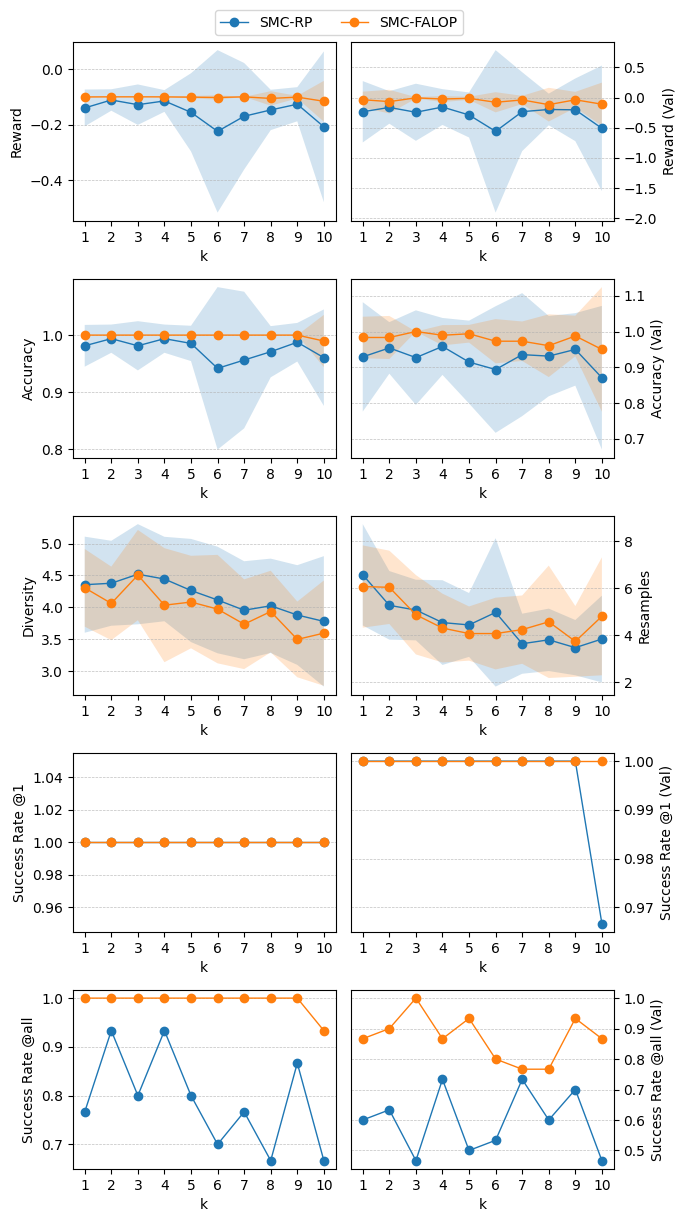

In [114]:
# plot code            
# fig, ax = plt.subplots(5, 2, figsize=(12, 15))
fig, ax = plt.subplots(5, 2, figsize=(7, 12))

# simple phi ordering: numeric phis (int/float) first, others after
def sort_key(x):
    if isinstance(x, (int, float, np.integer, np.floating)):
        return (0, float(x))
    return (1, str(x))

for idx, metric in enumerate(metric_list + additional_metrics):
    ax_i, ax_j = divmod(idx, 2)
    ax_ij = ax[ax_i, ax_j]

    if ax_j == 1:
        ax_ij.yaxis.tick_right()
        ax_ij.yaxis.set_label_position("right")


    x_values_sorted = sorted(list(plot_dict.keys()), key=sort_key)
    x = np.arange(len(x_values_sorted)) / 10

    for method in methods:
        # some metrics are only relevant to SMC
        hide_line = False
        if method in [IS_10K, BASE_MODEL] and metric in ["resamples"]:
            hide_line = True
        
        means_by_split_values = {}
        stds_by_split_values = {}
        for x_val in x_values_sorted:
            for split_vals in plot_dict[x_val].keys():
                if split_vals not in means_by_split_values:
                    means_by_split_values[split_vals] = []
                    stds_by_split_values[split_vals] = []
                means_by_split_values[split_vals].append(plot_dict[x_val][split_vals][method][metric][0])
                stds_by_split_values[split_vals].append(plot_dict[x_val][split_vals][method][metric][1])

        for split_vals, means in means_by_split_values.items():
            stds = stds_by_split_values[split_vals]
            means = np.array(means, dtype=float)
            stds = np.array(stds, dtype=float)
            # plot mean line
            label = method_labels.get(method, method)
            if len(split_by) > 0:
                label += " " + ", ".join(f"{k}={v}" for k, v in zip(split_by, split_vals))
            if hide_line:
                ax_ij.plot([], [], label=label)
            else:
                ax_ij.plot(x, means, label=label, marker='o', linewidth=1)

            # shaded area = mean +/- std
            lower = means - stds
            upper = means + stds
            ax_ij.fill_between(x, lower, upper, alpha=0.2)

    ax_ij.set_xticks(x)
    ax_ij.set_xticklabels([str(p//10) for p in x_values_sorted])
    ax_ij.set_xlabel(plot_x_label if plot_x_label else plot_x)
    ax_ij.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.8)

    ax_ij.set_ylabel(metric_labels.get(metric, metric))
    # no per-axis legend here
    
    # if "accuracy" in metric:
    #     ax_ij.set_ylim(0.6, 1)
    # if "success" in metric:
    #     ax_ij.set_ylim(0, 1)

# collect unique handles/labels from all axes and create a single legend at the top
handles = []
labels_unique = []
for a in ax.flatten():
    h, l = a.get_legend_handles_labels()
    for hi, li in zip(h, l):
        if li not in labels_unique:
            handles.append(hi)
            labels_unique.append(li)
    # remove any per-axis legend if present
    if a.get_legend() is not None:
        a.get_legend().remove()

# place figure legend above the subplots
if handles:
    fig.legend(handles, labels_unique, loc='upper center',
                ncol=len(labels_unique), bbox_to_anchor=(0.5, 1.02))

plt.tight_layout(rect=[0, 0, 1, 1])  # leave room at top for the legend

save_file = 'plots/smc_mdm_binarized_mnist_tempering_ablation.pdf'
# save_file=None
if save_file:
    plt.savefig(save_file, format="pdf", bbox_inches="tight")

plt.show()  

In [ ]:
def mean_and_std(values):
    mean = np.mean(values)
    std = np.std(values)
    return mean, std

metric_list = ["accuracy", "accuracy_ext", "reward", "reward_ext", "diversity", "resamples"]
additional_metrics = [
    "success_one", 
    "success_all", 
    "success_one_ext", 
    "success_all_ext"
]

BASE_MODEL = "BASE_MODEL"
IS_10K = "IS_10K"
SMC_LOP = "SMC_LOP"
SMC_RP = "SMC_RP"
SMC_FALOP = "SMC_FALOP"
methods = [
    # BASE_MODEL, 
    # IS_10K, 
    # SMC_RP, 
    SMC_FALOP
]
method_labels = {
    BASE_MODEL: "Base Model",
    IS_10K:     "IS@10K",
    SMC_RP:     "SMC-RP",
    SMC_FALOP:  "SMC-FALOP",
}
metric_labels = {
    "accuracy": "Accuracy",
    "accuracy_ext": "Accuracy (Val)",
    "reward": "Reward",
    "reward_ext": "Reward (Val)",
    "diversity": "Diversity",
    "resamples": "Resamples",
    "success_one": "Success Rate @1",
    "success_all": "Success Rate @all",
    "success_one_ext": "Success Rate @1 (Val)",
    "success_all_ext": "Success Rate @all (Val)",
}

def summarize_metrics(run_list):
    metric_dict = {}
    for run in run_list:
        metrics = run["metrics"]
        for metric in metric_list:
            if metric not in metric_dict:
                metric_dict[metric] = []
            metric_dict[metric].append(metrics[metric])
            
    metric_mean_and_std = {}
    
    for metric in metric_list:
        values = metric_dict[metric]
        mean, std = mean_and_std(values)
        metric_mean_and_std[metric] = (mean, std)
        
    accuracy_values = metric_dict["accuracy"]
    accuracy_ext_values = metric_dict["accuracy_ext"]
    
    success_one = sum(1 for v in accuracy_values if v > 0) / len(accuracy_values)
    success_all = sum(1 for v in accuracy_values if v == 1) / len(accuracy_values)
    success_one_ext = sum(1 for v in accuracy_ext_values if v > 0) / len(accuracy_ext_values)
    success_all_ext = sum(1 for v in accuracy_ext_values if v == 1) / len(accuracy_ext_values)
    
    metric_mean_and_std["success_one"] = (success_one, 0)
    metric_mean_and_std["success_all"] = (success_all, 0)
    metric_mean_and_std["success_one_ext"] = (success_one_ext, 0)
    metric_mean_and_std["success_all_ext"] = (success_all_ext, 0)
        
    return metric_mean_and_std


experiments_base_dir = 'outputs/smc_mdm_binarized_mnist_multi_runs'
metadata_file_name = 'metadata.json'
args_file_name = 'args.json'
results_file_name = 'all_experiments.pkl'

# Iterate over all dirs leaf dirs
all_experiment_dumps = []

filter_criteria = {
    "kl_weight": 1.0,
    "discretization_schedule": "cosine",
    "num_particles": 16,
    # "lambda_one_after": 30,
    "lambda_one_after": [10, 30, 100],
    "phi": 100,
    "use_partial_resampling": True,
}
split_by = [
    # "num_particles",
    # "kl_weight"
    # "discretization_schedule"
    "lambda_one_after",
]
# # plot_x = "lambda_one_after"
# # plot_x = "discretization_schedule"
# plot_x, plot_x_label = "num_particles", "Number of Particles"

plot_dict = {}
num_examples = 2
rows = 0

for root, dirs, files in os.walk(experiments_base_dir):
    if (results_file_name in files) and (metadata_file_name in files) and (args_file_name in files):
        # Load metadata and args
        with open(os.path.join(root, metadata_file_name), 'r') as f:
            metadata = json.load(f)
        with open(os.path.join(root, args_file_name), 'r') as f:
            args = json.load(f)
        with open(os.path.join(root, results_file_name), 'rb') as f:
            all_experiments = pickle.load(f)
        args_plus_metadata = metadata.copy()
        args_plus_metadata.update(args)
        
        # Check filter criteria
        match = True
        for key in filter_criteria.keys():
            if key not in args_plus_metadata:
                match = False
                break
            allowed_values = filter_criteria[key]
            if not isinstance(allowed_values, list):
                allowed_values = [allowed_values]
            if args_plus_metadata[key] not in allowed_values:
                match = False
                break
        
        if match:
            split_vals = tuple(args_plus_metadata[k] for k in split_by)
            assert plot_dict.get(split_vals) is None
            plot_dict[split_vals] = {}
            for method in methods:
                plot_dict[split_vals][method] = all_experiments[method]
                rows += 1
rows *= num_examples  

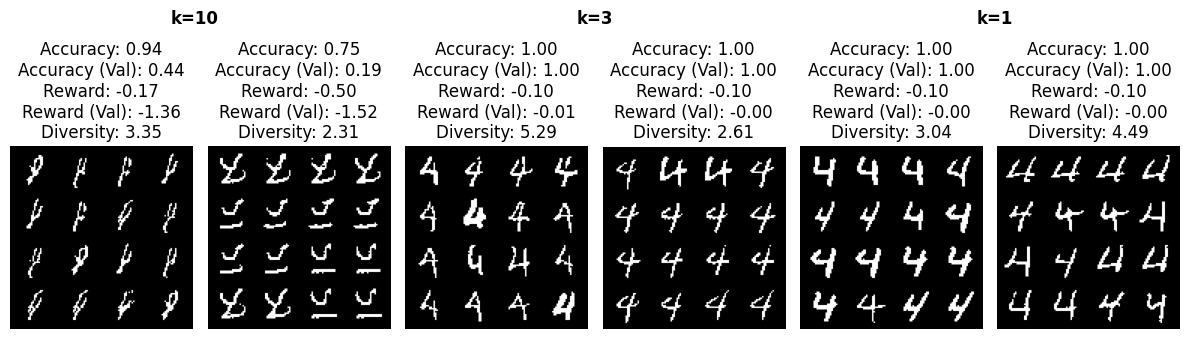

In [145]:
for offset in range(0, 2, 2):
    from torchvision.utils import make_grid
    fig, ax = plt.subplots(1, rows, figsize=(12, 6))
    col_idx = 0
    for method in methods:
        for split_vals in plot_dict.keys():
            examples = plot_dict[split_vals][method]
            for i, example in enumerate(examples[3:4] + examples[6:7]):
                a = ax[col_idx]
                samples = example["results"]["X_0"]
                if isinstance(samples, torch.Tensor):
                    samples = samples.float().cpu()
                else:
                    samples = torch.tensor(samples).float().cpu()
                grid = make_grid(samples, nrow=4, normalize=False)
                img = grid.numpy().transpose((1, 2, 0)).squeeze()
                a.imshow(img, cmap='gray')
                a.axis('off')
                # title = f"{method_labels.get(method, method)}"
                title = ""
                # if len(split_by) > 0:
                #     title += " " + ", ".join(f"{k}={v}" for k, v in zip(split_by, split_vals))
                for metric in metric_list:
                    if "resample" in metric:
                        continue
                    title += f"\n{metric_labels.get(metric, metric)}: {example['metrics'][metric]:.2f}"
                a.set_title(title)
                if col_idx % num_examples == 0:
                    a.set_ylabel(method_labels.get(method, method), fontsize=12)
                col_idx += 1
                
    for i, title in enumerate(["k=10", "k=3", "k=1"]):
        fig.text(
            (2*i + 1) / 6,     # center between 2 axes (normalized figure coords)
            0.95,              # y-position above plots
            title,
            ha="center",
            va="bottom",
            fontsize=12,
            fontweight="bold"
        )
        
    plt.tight_layout(rect=[0, 0, 1, 1.2])  # leave space for titles
    save_file = "plots/smc_mdm_mnist_tempering_ablation_samples.pdf"
    # save_file = None
    if save_file:
        plt.savefig(save_file, format="pdf", bbox_inches="tight")
    plt.show()

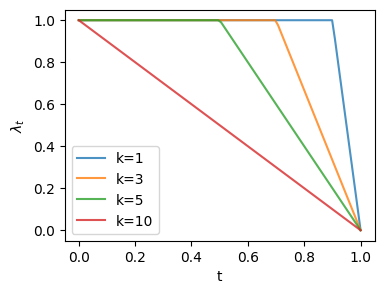

In [98]:
def lambda_t(t, k):
    return min(1.0, (10/k)*(1-t))

selected_ks = [1, 3, 5, 10]
ts = np.linspace(0, 1, 100)
plt.figure(figsize=(4, 3))
for k in selected_ks:
    lambdas = [lambda_t(t, k) for t in ts]
    plt.plot(ts, lambdas, label=f"k={k}", alpha=0.8)
    plt.xlabel("t")
    plt.ylabel(r"$\lambda_t$")

plt.legend(loc='best')

plt.savefig("plots/lambda_t_plot.pdf", format="pdf", bbox_inches="tight")
plt.show()